In [1]:
#AWS and Braket SDK imports.
import boto3
from braket.circuits import circuit, Circuit, Gate, Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
device = LocalSimulator()

#Matplotlib
from math import pi, log
import matplotlib.pyplot as plt
%matplotlib inline

def pow_2_divisor(n): #Returns highest power of 2 which divides given integer
    n = int(n) #Conversion from Sage-integer to standard int
    return int(log(n & (~(n - int(1))), 2))

In [9]:
@circuit.subroutine(register=True)
def qadd(A, B):
    circ = Circuit()
    circ.ccnot(A[0],B[0],B[1])
    circ.cnot(A[1],B[1])
    circ.cnot(A[0],B[0])
    return circ

@circuit.subroutine(register=True)
def qadd_inv(A, B):
    circ = Circuit()
    circ.cnot(A[0],B[0])
    circ.cnot(A[1],B[1])
    circ.ccnot(A[0],B[0],B[1])
    return circ

@circuit.subroutine(register=True)
def xor(A, B):
    circ = Circuit()
    for a,b in zip(A,B):
        circ.cnot(a,b)
    return circ

@circuit.subroutine(register=True)
def cxor(A, const):
    circ = Circuit()
    for a in A:
        c = const % 2
        const >>= 1
        if c: circ.x(a)
        else: circ.i(a)
    return circ

@circuit.subroutine(register=True)
def fs(A):
    pivot = len(A) // 2
    Al, Au = A[:pivot], A[pivot:]
    circ = Circuit()
    circ.xor(Al, Au)
    circ.xor(Au, Al)
    return circ

@circuit.subroutine(register=True)
def fs_inv(A):
    pivot = len(A) // 2
    Al, Au = A[:pivot], A[pivot:]
    circ = Circuit()
    circ.xor(Au, Al)
    circ.xor(Al, Au)
    return circ   
    
@circuit.subroutine(register=True)
def arxbox(A, B, const):
    circ = Circuit()
    A_rot = [-1,-1,1,1]
    B_rot = [1,-1,-1,1]
    for ar,br in zip(A_rot, B_rot):
        circ.qadd(A[::ar], B)
        circ.xor(B[::br], A)
        circ.cxor(B, const)
    return circ

@circuit.subroutine(register=True)
def arxbox_inv(A, B, const):
    circ = Circuit()
    A_rot = [1,1,-1,-1]
    B_rot = [1,-1,-1,1]
    for ar,br in zip(A_rot, B_rot):
        circ.cxor(B, const)
        circ.xor(B[::br], A)
        circ.qadd_inv(A[::ar], B)
    return circ

@circuit.subroutine(register=True)
def lambda2(XW, YW, AW):
    circ = Circuit()
    TX, TY = AW
    circ.xor(XW[0], TX)
    circ.xor(YW[0], TY)
    circ.fs(TX)
    circ.fs(TY)
    circ.xor(XW[0], XW[1])
    circ.xor(YW[0], YW[1])
    
    circ.xor(TX, YW[1])
    circ.xor(TY, XW[1])
    
    circ.fs_inv(TX)
    circ.fs_inv(TY)
    circ.xor(XW[0], TX)
    circ.xor(YW[0], TY)
    return circ

@circuit.subroutine(register=True)
def sparkle8(XW, YW, AW, loops):
    circ = Circuit()
    consts = [0x2,0x0,0x6,0x8,0xb,0x7,0x8,0xd]
    for s in range(loops):
        circ.cxor(YW[0], consts[s%8])
        circ.cxor(YW[1], s)
        for i in range(0,2):
            circ.arxbox(XW[i], YW[i], consts[i])
        circ.lambda2(XW, YW, AW)
    return circ

@circuit.subroutine(register=True)
def sparkle8_inv(XW, YW, AW, loops):
    circ = Circuit()
    consts = [0x2,0x0,0x6,0x8,0xb,0x7,0x8,0xd]
    for s in range(loops-1, -1, -1):
        circ.lambda2(XW, YW, AW)
        for i in range(0,2):
            circ.arxbox_inv(XW[i], YW[i], consts[i])
        circ.cxor(YW[0], consts[s%8])
        circ.cxor(YW[1], s)
    return circ

@circuit.subroutine(register=True)
def rho2(S1, S2, D):
    circ = Circuit()
    circ.xor(S1, S2)
    circ.fs(S1)
    circ.cxor(S1,D)
    circ.cxor(S2,D)
    return circ

@circuit.subroutine(register=True)
def rho2_inv(S1, S2, D):
    circ = Circuit()
    circ.cxor(S1,D)
    circ.cxor(S2,D)
    circ.fs_inv(S1)
    circ.xor(S1, S2)
    return circ

@circuit.subroutine(register=True)
def mcz(controls, theta = pi):
    lc = len(controls)
    circ = Circuit()
    if lc > 1:
        circ.mcz(controls[:-1], theta/2) #MCZ gate with one less control qubit
        theta = theta / pow(2, lc-1)
        circ.cnot(controls[-2], controls[-1])
        for i in range(1, pow(2, lc-1)):
            circ.rz(controls[-1], theta*pow(-1,i))
            index = pow_2_divisor(i)
            circ.cnot(controls[index], controls[-1])
        circ.rz(controls[-1], theta)
    else:
        circ.rz(controls[0], theta) # Base case, when there is only one qubit left
    return circ

@circuit.subroutine(register=True)
def flip(A, const):
    circ = Circuit()
    for a in A:
        c = const % 2
        const >>= 1
        if c: circ.i(a)
        else: circ.x(a)
    return circ

@circuit.subroutine(register=True)
def encrypt(K, N, A, MW, m):
    circ = Circuit()
    XW = [ [K[0], K[1]], [N[0], N[1]]]
    YW = [ [K[2], K[3]], [N[2], N[3]]]
    AW = [ [A[0], A[1]], [A[2], A[3]]]
    circ.sparkle8(XW,YW,AW,2)
    circ.rho2(N,MW[0],m[0])
    circ.sparkle8(XW,YW,AW,1)
    circ.rho2(N,MW[1],m[1])
    circ.sparkle8(XW,YW,AW,2)
    return circ
    
@circuit.subroutine(register=True)
def encrypt_inv(K, N, A, MW, m):
    circ = Circuit()
    XW = [ [K[0], K[1]], [N[0], N[1]]]
    YW = [ [K[2], K[3]], [N[2], N[3]]]
    AW = [ [A[0], A[1]], [A[2], A[3]]]
    circ.sparkle8_inv(XW,YW,AW,2)
    circ.rho2_inv(N,MW[1],m[1])
    circ.sparkle8_inv(XW,YW,AW,1)
    circ.rho2_inv(N,MW[0],m[0])
    circ.sparkle8_inv(XW,YW,AW,2)
    return circ

@circuit.subroutine(register=True)
def oracle(K, N, A, MW, m, c):
    circ = Circuit()
    circ.encrypt(K, N, A, MW, m)
    circ.flip(MW[0]+MW[1], (c[1]<<4) + c[0])
    circ.mcz(MW[0]+MW[1])
    circ.flip(MW[0]+MW[1], (c[1]<<4) + c[0])
    circ.encrypt_inv(K, N, A, MW, m)
    return circ

@circuit.subroutine(register=True)
def grover_mirror(X):
    circ = Circuit()
    circ.h(X)
    circ.x(X)
    circ.mcz(X)
    circ.x(X)
    circ.h(X)
    return circ

@circuit.subroutine(register=True)
def grover(K,N,A,MW,n,m,c,rounds):
    circ = Circuit()
    circ.cxor(N, n)
    circ.h(K)
    
    for _ in range(rounds):
        circ.oracle(K,N,A,MW,m,c)
        circ.grover_mirror(K)

    return circ

In [10]:
circ = Circuit()
K = [ 0, 1, 2, 3]
N = [ 4, 5, 6, 7]
A = [ 8, 9,10,11]
MW = [[12,13,14,15],[16,17,18,19]]

k = 0b0100
n = 0b1111 
m = [0b0111,0b1000]

circ.cxor(N, n)
circ.cxor(K, k)
circ.encrypt(K, N, A, MW, m)

task = device.run(circ, shots=10)
result = task.result()
counts = result.measurement_counts

for k in counts.keys():
    print(k[::-1])
    c1 = k[::-1][0:4]
    c0 = k[::-1][4:8]
    print(f"c = [0b{c0}, 0b{c1}]")

01011110000010011001
c = [0b1110, 0b0101]


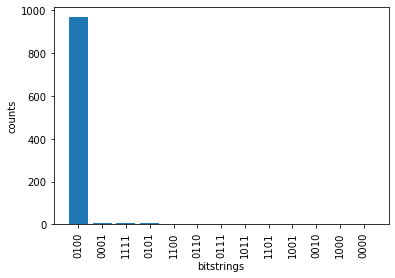

In [12]:
circ = Circuit()

K = [ 0, 1, 2, 3]
N = [ 4, 5, 6, 7]
A = [ 8, 9,10,11]
MW = [[12,13,14,15],[16,17,18,19]]

n = 0b1111 
m = [0b0111,0b1000]
c = [0b1110, 0b0101]

rounds = 3

circ.grover(K,N,A,MW,n,m,c,rounds)

task = device.run(circ, shots=1000)
result = task.result()
counts = result.measurement_counts
    
plt.bar([k[:4][::-1] for k in counts.keys()], counts.values())
plt.xlabel('bitstrings');
plt.ylabel('counts');
_ = plt.xticks(rotation = 90)